In [1]:
import logging
# set seed
from pprint import pprint
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import utils as ut
import experiment as exp
import evaluation as ev
from pathlib import *
import torch
import random
import regex as re
import plot
from river import stream,linear_model,preprocessing, ensemble, metrics, optim
import matplotlib.pyplot as plt
from sk_models import LocalWeightedRegression, PCR, setup_pls_models, PLSRegression, LinearRidge, CustomWrapper

In [2]:
seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)

random_state = np.random.RandomState(seed)

In [3]:
#we need to set parametesr
file_name = "PLN7.csv"#"PLN7.csv" A_FE_RT  A_C_OF_alpha #"mango_513_1050.csv" #"mango_684_990.csv" #"mango_729_975.csv"
id_cols =[]#["sample_id"] "db_id","sample_id"
n_comps = [i for i in range(1,101)]

data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/10.1")

In [4]:
data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
print(log_dir)

data = pd.read_csv(data_file)
nrow, ncol = data.shape
data = ut.sample_data(data,random_state)

n_features = ncol - 1-len(id_cols)
dataset = ut.TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=None, ignore_cols= None)

# todo write a summary
#ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
#tb = SummaryWriter(log_dir/"tb")
print(log_dir)

D:\workspace\lazydeep\experiments\10.1\PLN7
D:\workspace\lazydeep\experiments\10.1\PLN7


In [5]:
def take_subset_by_str(dataset,string,reverse=False):
    col_names = dataset.columns.tolist()
    if reverse:
        encoding = [i for i in col_names if not (string in i)]
    else:
        encoding = [i for i in col_names if (string in i)]
    return dataset[encoding]


rolling  = pd.read_csv(log_dir/"r2_scores_rolling.csv",index_col=0)
total= pd.read_csv(log_dir/"R2.csv",index_col=0)


In [6]:
plt.style.use('seaborn-darkgrid')

name_dict ={'lr':f'LR',
           'lr_norm':f'LR$_s$',
           'ridge':f'LR$_r$',
           'ridge_norm':r'LR$_{s,r}$',
           'pcr':f'PCR',
           'pcr_scale':f'PCR$_s$',
           'pcr_whiten':f'PCR$_w$',
           'pcr_s_w':r'PCR$_{s,w}$',
           'plsr':f'PLSR',
           'plsr_scale':f'PLSR$_s$',  
           'pls_lwr':f'PLS-LWR',
           'pls_deep':f'PLS-Deep',
            'lwr':f'LWR',
            'pls_deep_lwr':f'PLS-Deep-LWR',
            'deep':f'Std-Deep',
            'deep_lwr':f'Std-Deep-LWR',
            'lin0':'LR',
            'lin1':f'LR$_s$',
            'lin2':f'LR$_r$',
            'lin3':r'LR$_{s,r}$',
            'lwr1':f'LWR',
            'lwr2':f'LWR$_s$',
            'knn1':f'kNN',
            'knn2':f'kNN$_s$',
            'std-deep-lwr':'Std-Deep-LWR',
            'std-deep-lwr_e1':r'Std-Deep-E$_1$(LWR)',
            'std-deep-lwr_e2':r'Std-Deep-E$_2$(LWR)',
            'std-deep-lwr_e3':r'Std-Deep-E$_3$(LWR)',
            'std-deep-lwr_e4':r'Std-Deep-E$_4$(LWR)',
            'std-deep-lwr-s11':r'Std-Deep-E$_5$(LWR)',
            'pls-deep-lwr':'Std-Deep-LWR',
            'pls-deep-lwr_e1':r'PLS-Deep-E$_1$(LWR)',
            'pls-deep-lwr_e2':r'PLS-Deep-E$_2$(LWR)',
            'pls-deep-lwr_e3':r'PLS-Deep-E$_3$(LWR)',
            'pls-deep-lwr_e4':r'PLS-Deep-E$_4$(LWR)',
            'pls_deep_lwr-s11':r'PLS-Deep-E$_5$(LWR)'
          }

    

def take_subset_by_re(dataset,s,reverse=False):
    col_names = dataset.columns.tolist()
    if reverse:
        encoding = [i for i in col_names if not s.match(i)]
    else:
        encoding = [i for i in col_names if s.match(i)]
    return dataset[encoding]
    
def clean_data(x):
    if type(x) is str:
        x = x.replace('[','').replace(']','')
        x = float(x)
    if type(x) == list:
        #print(x)
        return x[0]
    else:
        return x

#$print "Location: %-*s  Revision: %s" % (20,"10-10-10-10","1")

E(pls-deep)
E(pls-deep-lwr)
pls-deep0-E(lwr)
pls-deep1-E(lwr)
pls-deep2-E(lwr)
pls-deep3-E(lwr)
pls-deep4-E(lwr)


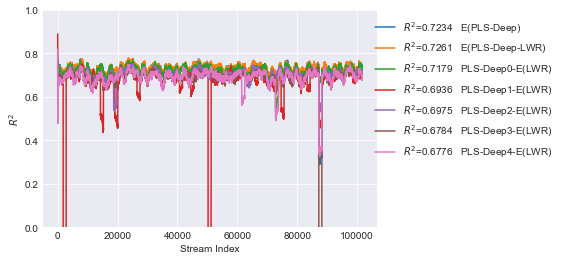

In [7]:
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel(f"$R^2$")
subset = take_subset_by_str(rolling,"pls")
for (columnName, columnData) in subset.iteritems():
    print(columnName)
    x = [clean_data(x) for x in columnData.tolist()]
    score = x[len(x)-1]
    label = r"$R^2$=" + "{:.4f}".format(score) +"   " + columnName.replace('pls','PLS').replace('deep','Deep').replace('lwr','LWR').replace('deep0',r'Deep$_0$').replace('deep1',r'Deep$_1$').replace('deep2',r'Deep$_2$').replace('deep3',r'Deep$_3$').replace('deep4',r'Deep$_4$')    
    ax.plot(columnData.index,x,label=label)  

    
ax.legend(loc='upper right',bbox_to_anchor=(1.55, 1))
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_rolling_v2_pls_deep_lwr_e.png",bbox_inches='tight')

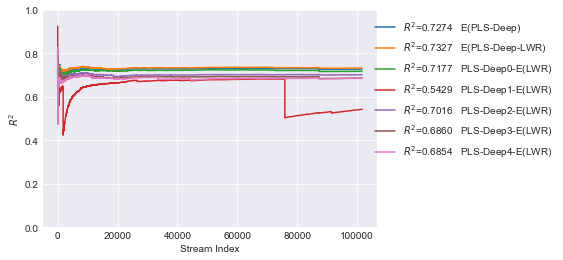

In [8]:
fig, ax = plt.subplots()

ax.set_xlabel("Stream Index")
ax.set_ylabel(f"$R^2$")
subset = take_subset_by_str(total,"pls")
for (columnName, columnData) in subset.iteritems():
    x = [clean_data(x) for x in columnData.tolist()]
    score = x[len(x)-1]
    if score < -10:
            score = -9.9999
    label = r"$R^2$=" + "{:.4f}".format(score) +"   " + columnName.replace('pls','PLS').replace('deep','Deep').replace('lwr','LWR').replace('deep0',r'Deep$_0$').replace('deep1',r'Deep$_1$').replace('deep2',r'Deep$_2$').replace('deep3',r'Deep$_3$').replace('deep4',r'Deep$_4$')    
    ax.plot(columnData.index,x,label=label)   

ax.legend(loc='upper right',bbox_to_anchor=(1.55, 1))
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_v2_pls_deep_lwr_e.png",bbox_inches='tight')